# 08. PyTorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch.

See ground truth notebook here: https://www.learnpytorch.io/08_pytorch_paper_replicating/


# 0. Get setup

Let's import code we've previously written + required libraries.

In [ ]:
import torch
import torchvision

In [ ]:
t# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1457), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 21.58 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

The whole goal of what we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need some data.

Namely, the pizza, steak and sushi images we've been using so far.

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [ ]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224 # comes from the Table 3of the paper

# Create transfomrs pipeline
manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our smaller hardware... can always scale up later)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

As always, let's adhere to the motto, *visualize, visualize, visualize!*

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

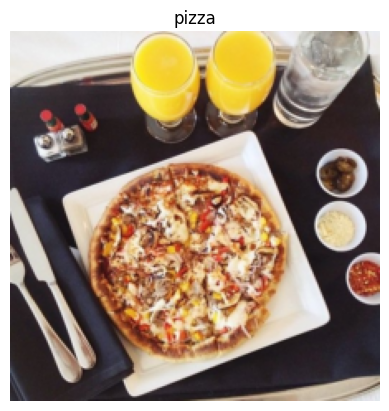

In [ ]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

### 3. Replicating Vit: Overview

Looking at a whole ML research paper can be intimidating.

In order to make it more understandale, we can break it down into smaller pieces.

*  **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block> (in our case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention)
* **Blocks** - A collection of layers.
* **Model (or architecture)** - A collection of blocks.

### 3.1 ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training
* Text

### Figure 1

<img src ="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper">

* Embedding - learnable representation (start with random numbers and improve them over time)




### Four equations

<img src ="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width =600 alt="four equations from vision transformer paper"/>

In all equations (except equation 4), "$\mathbf{z}$" is the raw output of a particular layer:

1. $\mathbf{z}_{0}$ is "z zero" (this is the output of the initial patch embedding layer).
2. $\mathbf{z}_{\ell}^{\prime}$ is "z of a particular layer prime" (or an intermediary value of z).
3. $\mathbf{z}_{\ell}$ is "z of a particular layer".
And $\mathbf{y}$ is the overall output of the architecture.



### Section 3.1 describes the various equations:

**Equation 1:**

An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. I). We refer to the output of this projection as the patch embeddings.


**Equation 1:**

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_path_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_2_pos, ... image_patch_N_pos]
```

---

**Equation 2 & 3:**

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

```


**Equation 4:**

Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches ( $\mathbf{z}_0^0=\mathbf{x}_{\text {class }}$ ), whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $y$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.


* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hiden layer at training time
* MLP = single linear layer at fine-tuning time

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```

### Table 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture.
* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/ neurons in our MLP
* Heads - the number of multi-head self-attention

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output.

What's the input shape?

What's the output shape?

* Input shape: (224,224,3) -> single image -> (height, width, color channels)
* Output shape: ???

### 4.1 Calculate input and output shapes by hand

>**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. I). We refer to the output of this projection as the patch embeddings.

> **Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input image: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N\times\left(P^{2} \ cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / P^2
* D = constant latent vector size = embbeding dimension (Table 1)


In [ ]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16


# Calculate the number of pathes
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [ ]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embbeding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embbeding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


### 4.2 Turning a single image into patches

Let's *visualize, visualize, visualize!*

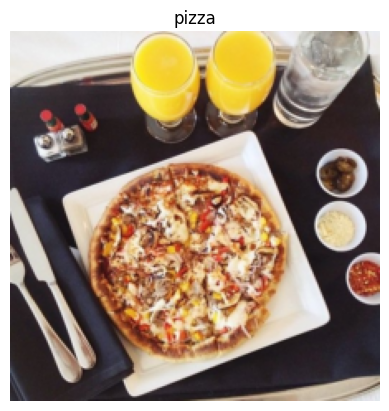

In [ ]:
# View a singe image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
image.shape

torch.Size([3, 224, 224])

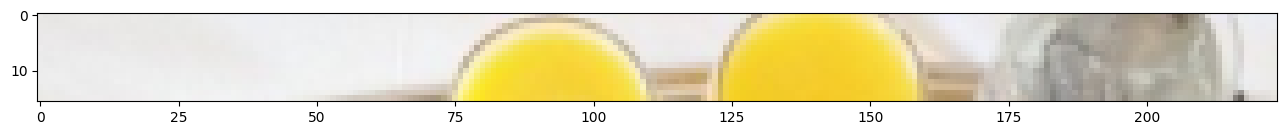

In [ ]:
# Get the top row of the image
image_permuted = image.permute(1,2,0) # convert image to color channels last (H,W,C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


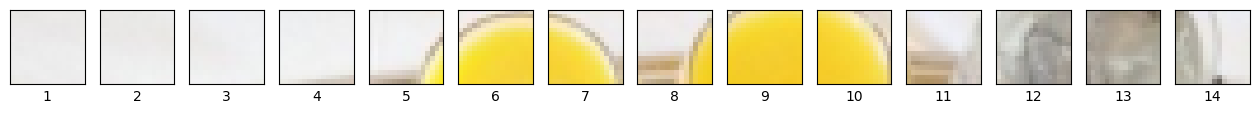

In [ ]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows = 1,
                        ncols=img_size // patch_size,#one coloumn for each patch
                        sharex=True,
                        sharey = True,
                        figsize =(patch_size, patch_size) )

# Iterarte through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch: patch+patch_size, :]);
  axs[i].set_xlabel(i+1) #set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches: 196 (14x14)
Each patch is 16x16 pixels


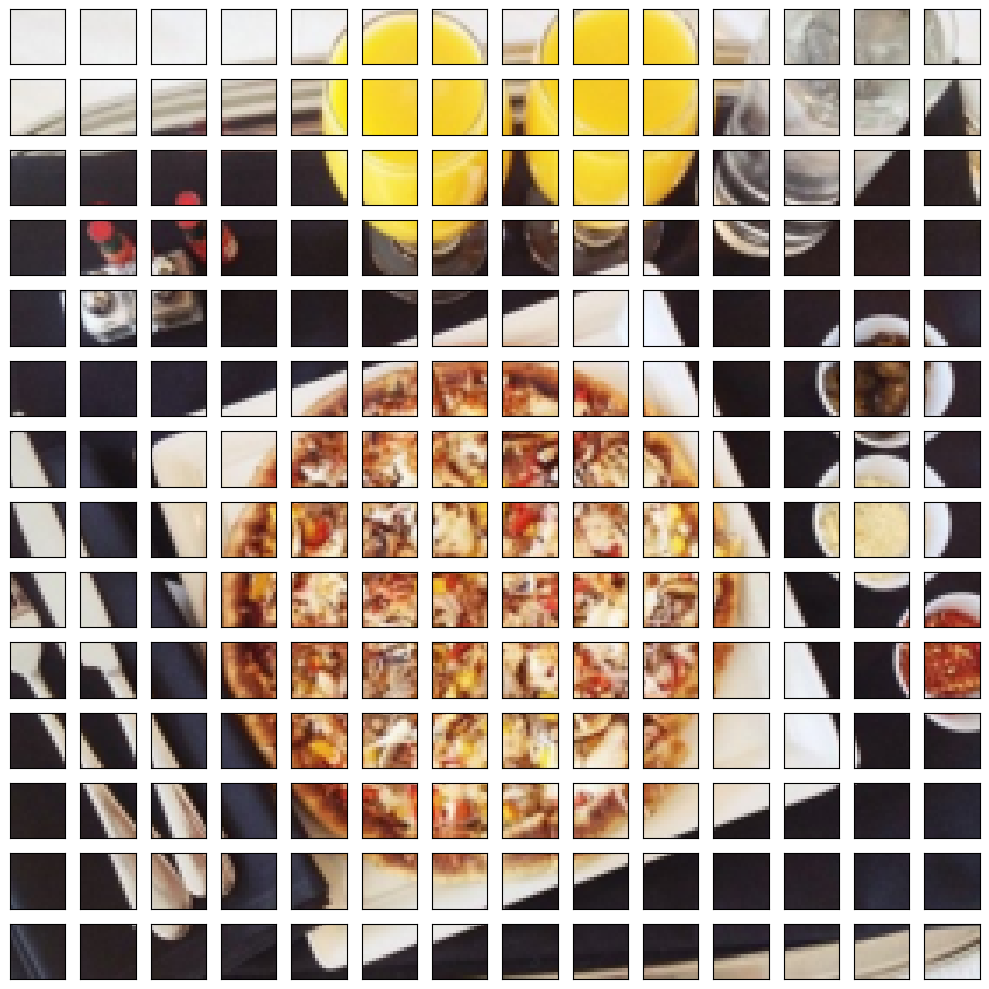

In [ ]:
import matplotlib.pyplot as plt

# Image and patch configuration
img_size = 224
patch_size = 16
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
num_patches_per_row = img_size // patch_size

print(f"Number of patches: {num_patches_per_row**2} ({num_patches_per_row}x{num_patches_per_row})")
print(f"Each patch is {patch_size}x{patch_size} pixels")

# Create the full patch grid (14x14 = 196)
fig, axs = plt.subplots(nrows=num_patches_per_row,
                        ncols=num_patches_per_row,
                        figsize=(10, 10))

# Loop over rows and columns to show all patches
for row in range(num_patches_per_row):
    for col in range(num_patches_per_row):
        patch = image_permuted[
            row * patch_size : (row + 1) * patch_size,
            col * patch_size : (col + 1) * patch_size,
            :
        ]
        axs[row, col].imshow(patch)
        axs[row, col].set_xticks([])
        axs[row, col].set_yticks([])

plt.tight_layout()
plt.show()


Number of patches per row: 14.0      
Number of patches per column: 14.0      
Total patches: 196.0      
Patch size: 16 pixels x 16 pixels


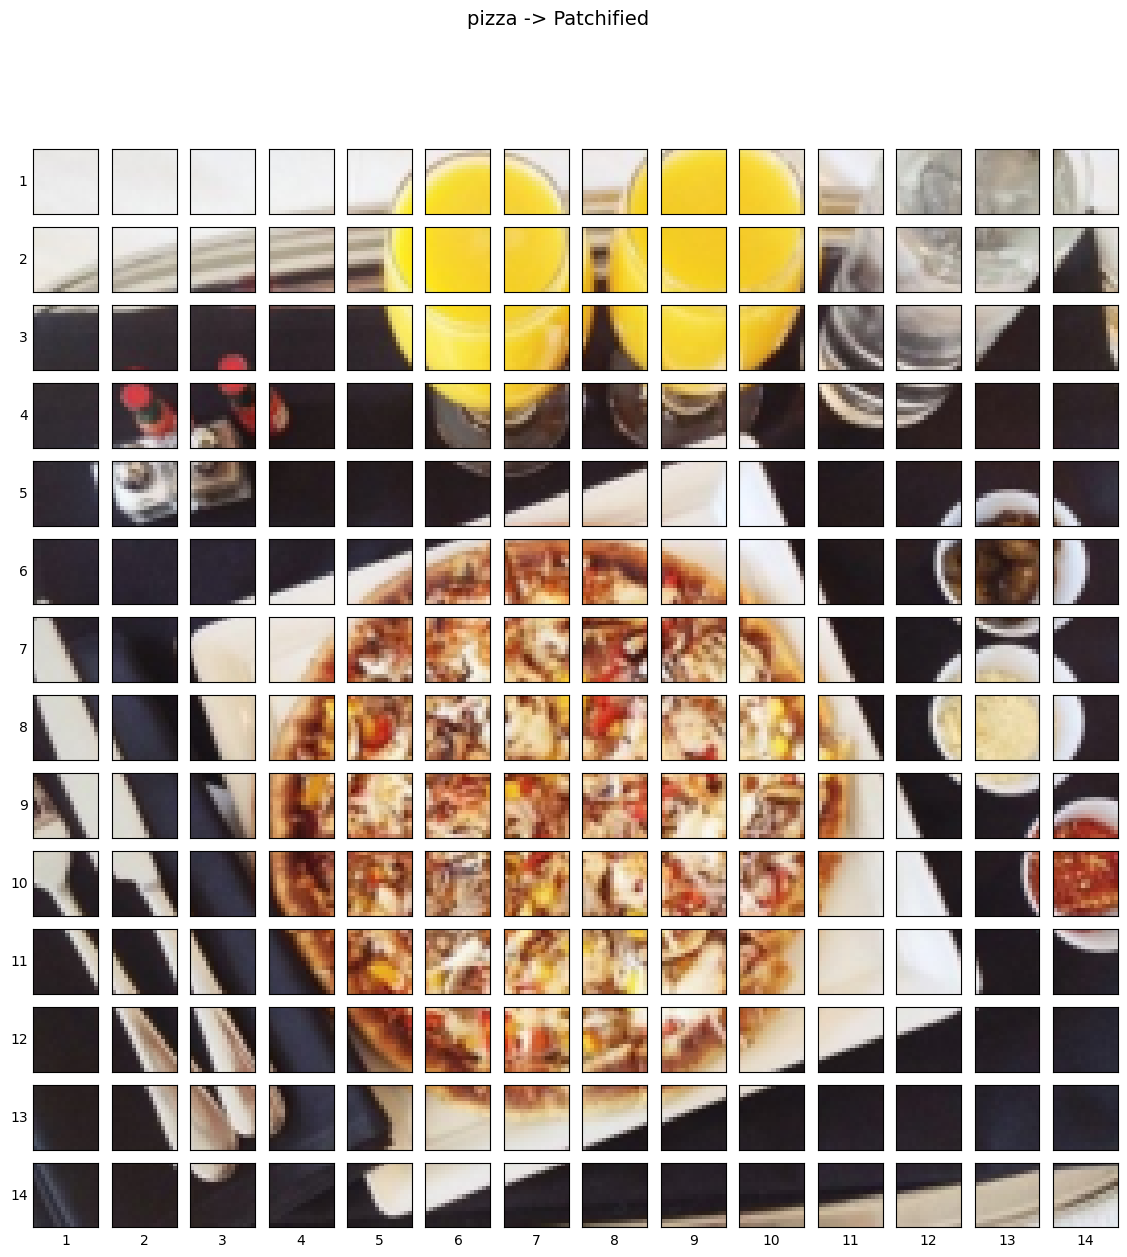

In [ ]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0 , "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
      \nNumber of patches per column: {num_patches}\
      \nTotal patches: {num_patches * num_patches}\
      \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize = (num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through heigh
  for j, patch_width in enumerate(range(0,img_size, patch_size)):
    # Plot the permuted image on the different axes
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through the height
                                   patch_width:patch_width+patch_size, # iterate through width
                                   :])# get all color channels
    # Setup label information for each subplot (patch)
    axs[i,j].set_ylabel(i+1,
                        rotation="horizontal",
                        horizontalalignment="right",
                        verticalalignment="center")
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()

# Set up a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()


### 4.3 Creating image patches and turning them into patch embeddings

Perhaps we could create the image patches and images patch embedding in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`.



In [ ]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3,# for color images
                   out_channels = 768, # D size from Table1
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

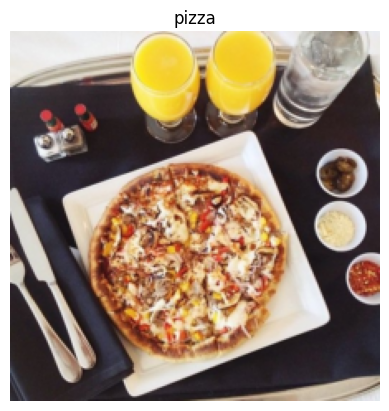

In [ ]:
# View single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to our `conv2d` layer, its shape is:

```python
torch.shize([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [4, 696, 13, 263, 538] 


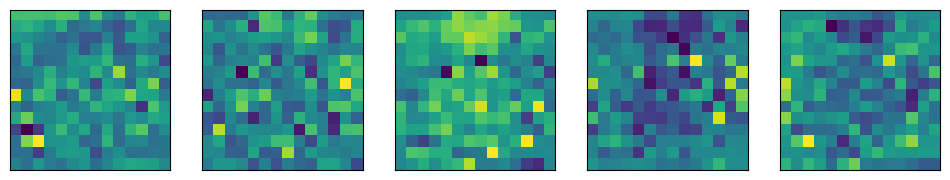

In [ ]:
# Plot random convolutional features maps(embeddings)
import random
random_indexes = random.sample(range(0,758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes} ")

# Create plot
fig,axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  img_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor
  axs[i].imshow(img_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
# Get a single feature map in tnesor form
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map

tensor([[[-1.6814e-01, -1.7145e-01, -1.7481e-01, -1.8010e-01, -7.7849e-02,
          -4.3456e-02, -1.5339e-01, -2.0598e-02,  1.0725e-02, -1.6941e-01,
          -8.7177e-02, -1.3882e-01, -7.3171e-02, -2.0195e-01],
         [-7.7707e-02, -1.2311e-01,  2.9969e-02,  1.0826e-02,  6.3782e-02,
          -2.5744e-02, -7.4387e-02,  5.8369e-02, -4.4418e-02, -8.5963e-02,
           1.1849e-01, -8.2533e-02, -1.8250e-01,  6.7456e-02],
         [ 7.2106e-03, -2.8971e-02, -4.9306e-02, -1.3874e-02, -8.0657e-02,
           6.0157e-02, -2.4920e-02,  1.8550e-01, -4.6753e-02,  7.1441e-03,
          -2.4389e-01, -3.6767e-02, -1.9575e-02, -1.0392e-01],
         [-4.8881e-02, -4.1575e-02, -2.0149e-01, -2.8939e-02, -2.8728e-02,
           8.4357e-02,  8.1520e-03, -4.7399e-02, -1.1868e-02, -1.4355e-01,
           1.7861e-01,  3.6427e-02, -4.2827e-02, -4.7164e-02],
         [-6.7895e-02,  1.7641e-02,  4.7799e-02, -4.6346e-02, -4.2659e-02,
          -5.5680e-04, -3.1848e-01, -3.6099e-01, -1.6730e-01, -1.0596e-01

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've a series onf convolutional features maps (patch embeddings) that we want to flatten into a sequences of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [ ]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feauture_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feauture_map_width)


Want: (batch_size, number_of_patches, embedding_dim)

In [ ]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flatten image features map shape: torch.Size([1, 768, 196])


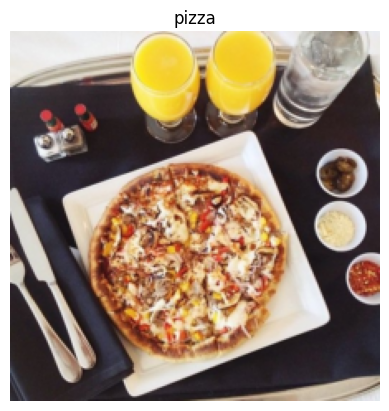

In [ ]:
# Put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flatten image features map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Rearrange output of flattned layer
image_out_of_conv_flattened_permuted =  image_out_of_conv_flattened.permute(0,2,1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimensions)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimensions)


Recap:

* *Number of patches:* is the number of smaller square patches the image is divide into.
number_of_patches = (image_height / patch_size) * (image_widht / patch_size)

* *Embedding Dimensions:* each patch is flattened into a vector, and then projected into a higher-dimensional space using a linear layer. That resulting vector has a size called the embedding dimension.

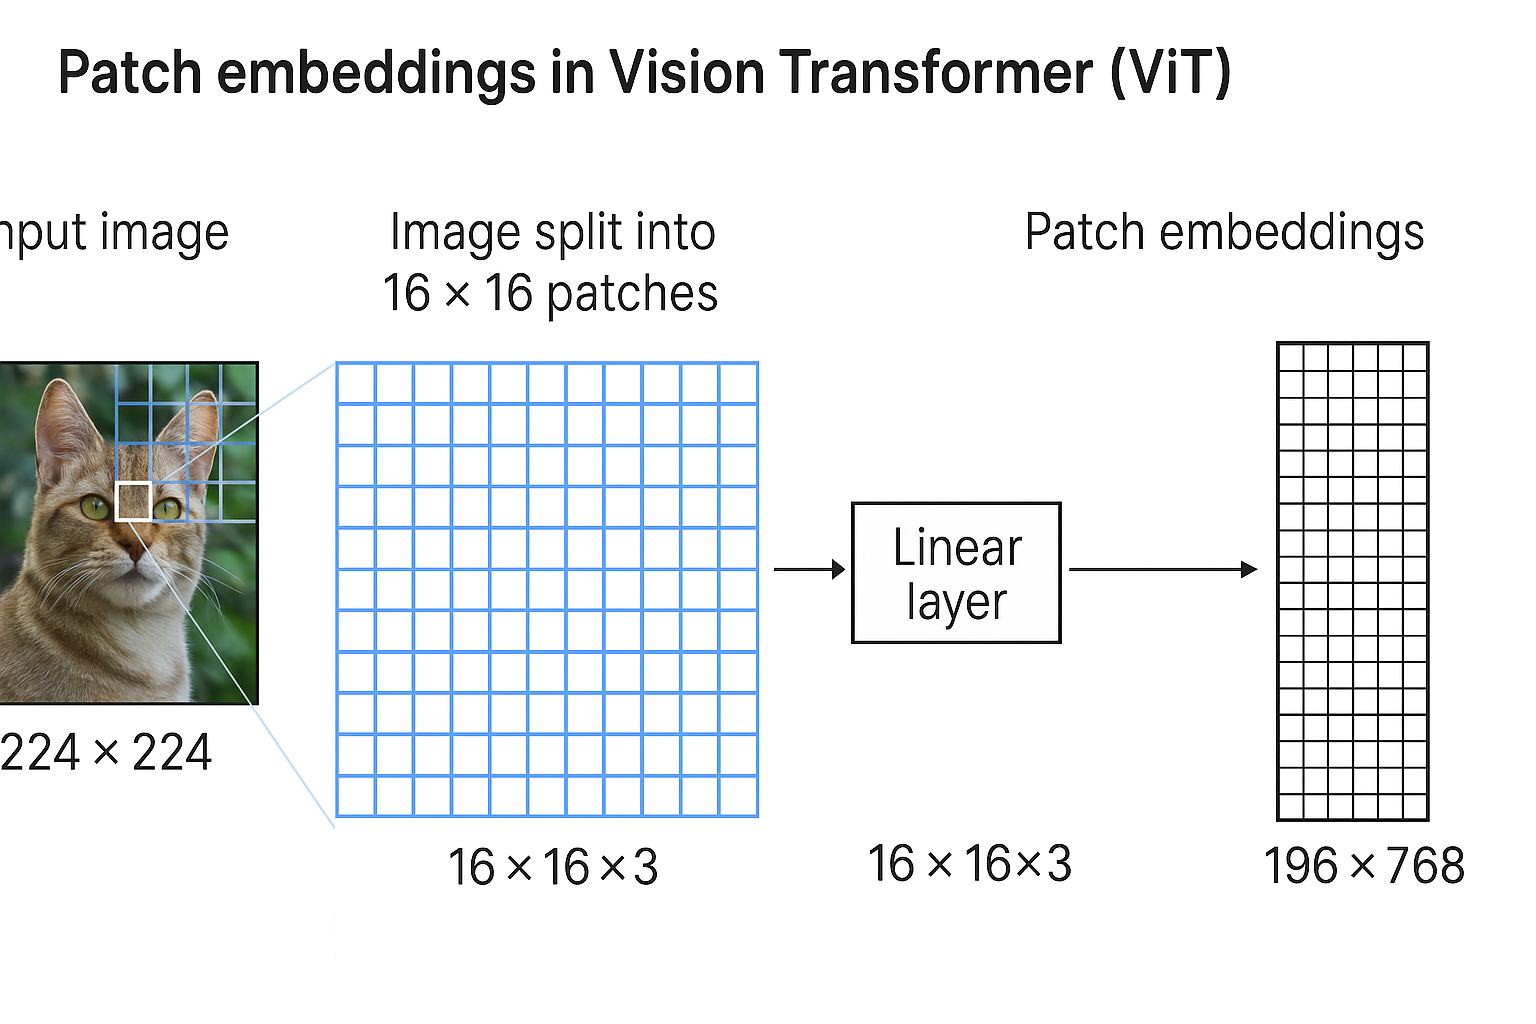

Instead of feature maps from convolutions, ViT:

 * **Splits the image into patches**

 * **Flattens** each patch

 * **Projects** it into an embedding vector using a linear layer

 * The collection of these vectors is like a **flattened feature map**, where each vector represents a patch

So the concept of a feature map still exists, but in vector form instead of 2D grids.




`feature_map_height` and `feature_map_width` refer to the spatial dimensions of the output feature map (a tensor) after passing an image through some convolutionar of patch-based operations.

* `feature_map_height`: the height (number of rows) of the feature map = img_size // patch_size
* `feature_map_width`: the width(number of columns) of the feature map = img_size // patch_size

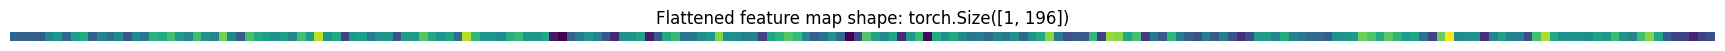

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:,:,0]

# Plot the flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a clas called `PatchEmbedding` that inherits from `nn.Module`
2. Initialize with appropiate hyperparameters, such as channels, embedding dimensions, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the features maps of the outputs of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflect the required output shape of the patch embedding.

In [ ]:
# 1. Create a class called PathEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropiate hyperparameters
  def __init__(self, in_channels:int = 3,
               patch_size: int = 16,
               embedding_dim: int = 768): # from table1 for ViT-Base
    super().__init__()

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten feature map outputs of conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  # 5. Define a forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisbile by patch size, image shape: {image_resolution}, patch size: {self.patch_size} "

    # Perfomr the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6. Make sure the returned sequence embedding dimensions are in the right order
    # (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0, 2, 1)

In [ ]:
set_seeds(42)

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [ ]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad= torch.randn(1,3, 250, 250)

patchify(rand_image_tensor)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

### 4.6 Creating the class token embedding

Want to: prepend a learneable class token to the start of the path embedding.

In [ ]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0] #first dimension od the image, which is the batch size
embedding_dimension  =patch_embedded_image.shape[-1] # last dimension, which is the embedding dimension
# we acceseed the batch_size and the embedding_dimension through the embedde_image

batch_size, embedding_dimension

(1, 768)

In [ ]:
# Create class token embedding as a learnable parameters that shares the same size as the embedding dimension (D)
# we use nn.Parameter() to make the token learnable
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
# Add the class token embedding to the from of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim = 1) # number_of_patches dimenson
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepened shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9559,  0.2557, -0.2788,  ...,  0.7270, -0.4252,  0.3416],
         [-0.9550,  0.2627, -0.2936,  ...,  0.7346, -0.4259,  0.3391],
         ...,
         [-0.5510,  0.0263, -0.4428,  ...,  0.4074, -0.0395,  0.4125],
         [-0.7707,  0.2181, -0.2003,  ...,  0.2947, -0.0903,  0.3046],
         [-0.7969,  0.2857, -0.3141,  ...,  0.5529, -0.2730,  0.2207]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepened shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


Position embeddings shape:
(num_patches + 1, embedding_dimension) (+1 is for the class_token)

### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

Position embedding help inject information about the order of position of patches into the model

How to create position embeddings

Let's assume:
 * Your image is split into `N` patches.
 * Each patch is embedded into a vector of size `D` (the embedding dimension).
 * You want to add position information to each patch embedding.

In [ ]:
# Calculate N (number_of_patches)
number_of_patches = int((height*width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension))
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

Why `1, num_of_patches + 1, embedding_dim`?
 * `1`: batch size for broadcasting
 * `num_patches + 1`: one position for each patch plus one for the [CLS] (class  token embedding)
 * `embedding_dim`: same dimensionality as your patch embeddings.

In [ ]:
# View the sequence of patch embedding with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9559,  0.2557, -0.2788,  ...,  0.7270, -0.4252,  0.3416],
          [-0.9550,  0.2627, -0.2936,  ...,  0.7346, -0.4259,  0.3391],
          ...,
          [-0.5510,  0.0263, -0.4428,  ...,  0.4074, -0.0395,  0.4125],
          [-0.7707,  0.2181, -0.2003,  ...,  0.2947, -0.0903,  0.3046],
          [-0.7969,  0.2857, -0.3141,  ...,  0.5529, -0.2730,  0.2207]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.0441, 1.2557, 0.7212,  ..., 1.7270, 0.5748, 1.3416],
         [0.0450, 1.2627, 0.7064,  ..., 1.7346, 0.5741, 1.3391],
         ...,
         [0.4490, 1.0263, 0.5572,  ..., 1.4074, 0.9605, 1.4125],
         [0.2293, 1.2181, 0.7997,  ..., 1.2947, 0.9097, 1.3046],
         [0.2031, 1.2857, 0.6859,  ..., 1.5529, 0.7270, 1.2207]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together: from image to embedding

We've written code to turn an image in a flattened sequnce of patch embeddings.

Now let's see it all in one cell.

In [ ]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through PathcEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create a class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size ,1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable

print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad = True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multihead Self-Attention (MSA block)

* Multihead self-attention: which part of a sequence should pay the most attention to itself?
 * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
 * We want our neural network (ViT) to learn this relationship/representation.

* To replicate MSA in PyTorch we can use: https://docs.pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

* LayerNorm = Layer nromalization (LayerNorm) is a technique to normalize the distribution of the intermediate layers. It enables smoother gradients, faster training and better generalization accuracy.
  * Normalization = makes everythin have the same mean and same stander deviation
  * In PyTorch = https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm ,
  normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
    * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size.
    

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """
  Creates a multi-head self-attention block ("MSA block")
  """
  def __init__(self,
               embedding_dim: int = 768, # size D from Table 1
               num_heads: int = 12, # from Table 1
               dropout: float = 0.0):
    super().__init__()
    # Create LayerNorm layer(LN)
    self.layer_norm = torch.nn.LayerNorm(normalized_shape=embedding_dim)

    # Create MultiHead attention (MSA) layer
    self.MSA = torch.nn.MultiheadAttention(embed_dim=embedding_dim,
                                           num_heads = num_heads,
                                           dropout = dropout,
                                           batch_first= True) # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embeding_dimension)

  def forward(self,x):
    x = self.layer_norm(x)
    attn_output, _ = self.MSA(query = x,
                              key = x,
                              value = x,
                              need_weights = False)
    return attn_output

In [ ]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads = 12,
                                                             dropout = 0.0)

# Passs the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shapes of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shapes of MSA block: torch.Size([1, 197, 768])


In [ ]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.0441, 1.2557, 0.7212,  ..., 1.7270, 0.5748, 1.3416],
         [0.0450, 1.2627, 0.7064,  ..., 1.7346, 0.5741, 1.3391],
         ...,
         [0.4490, 1.0263, 0.5572,  ..., 1.4074, 0.9605, 1.4125],
         [0.2293, 1.2181, 0.7997,  ..., 1.2947, 0.9097, 1.3046],
         [0.2031, 1.2857, 0.6859,  ..., 1.5529, 0.7270, 1.2207]]],
       grad_fn=<AddBackward0>)

In [ ]:
patched_image_through_msa_block

tensor([[[-0.2485, -0.2174,  0.0821,  ..., -0.4264,  0.8735, -0.4967],
         [-0.2580, -0.1978,  0.0967,  ..., -0.4231,  0.8889, -0.5088],
         [-0.2578, -0.1977,  0.0970,  ..., -0.4229,  0.8889, -0.5089],
         ...,
         [-0.2610, -0.1953,  0.0977,  ..., -0.4186,  0.8928, -0.5071],
         [-0.2609, -0.1947,  0.0939,  ..., -0.4155,  0.8902, -0.5068],
         [-0.2554, -0.1972,  0.0972,  ..., -0.4197,  0.8889, -0.5110]]],
       grad_fn=<TransposeBackward0>)

## 6. Equation 3: Multilayer Perceptron (MLP)

* **MLP** = the MLP contains two layers with a GELU non-linearity (section 3.1).
  * MLP = a quiet broad term for a block with a series of layer (s), layers can be multiple or even only one hidden layer.
  * Layers can mean: fully-connected, dense, linear, feedforward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` and in TensorFlow they migth be called `tf.keras.layers.Dense()`
  * GELU in PyTorch - https://docs.pytorch.org/docs/stable/generated/torch.nn.GELU.html#gelu

* **Dropout** = when used, is applied after every dense layer except for the qkv-projections and directly after adding positional- to patch embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.
  * Value for Dropout available in Table 3

In pseudocode:
```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [ ]:
class Multilayer(nn.Module):
  def __init__(self,
               embedding_dimension: int = 768,
               mlp_size: int = 3072,
               dropout: float = 0.1):
     super().__init__()

     # Create the Norm layer (LN)
     self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)

     # Create the MultiLayer Perceptron (MLP)
     self.MLP = nn.Sequential(
         nn.Linear(in_features=embedding_dimension,
                   out_features=mlp_size),
         nn.GELU(),
         nn.Dropout(p= dropout),
         nn.Linear(mlp_size, embedding_dimension),
         nn.Dropout(p=dropout)
     )

  def forward(self,x):
    x = self.layer_norm(x)
    x = self.MLP(x)
    return x
    # return self.MLP(self.layer_norm(x))

In [ ]:
# Create an instance of MLPblock
multilayer_block = Multilayer(embedding_dimension=768,
                              mlp_size=3072,
                              dropout=0.1)

# Pass MSAblock through MLPblock
patched_image_through_mlp_block = multilayer_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [ ]:
patched_image_through_msa_block

tensor([[[-0.2485, -0.2174,  0.0821,  ..., -0.4264,  0.8735, -0.4967],
         [-0.2580, -0.1978,  0.0967,  ..., -0.4231,  0.8889, -0.5088],
         [-0.2578, -0.1977,  0.0970,  ..., -0.4229,  0.8889, -0.5089],
         ...,
         [-0.2610, -0.1953,  0.0977,  ..., -0.4186,  0.8928, -0.5071],
         [-0.2609, -0.1947,  0.0939,  ..., -0.4155,  0.8902, -0.5068],
         [-0.2554, -0.1972,  0.0972,  ..., -0.4197,  0.8889, -0.5110]]],
       grad_fn=<TransposeBackward0>)

In [ ]:
patched_image_through_mlp_block

tensor([[[-0.0417, -0.0109,  0.1389,  ...,  0.0000, -0.1626,  0.1877],
         [-0.0903, -0.1229,  0.2518,  ..., -0.0859, -0.1423,  0.2098],
         [-0.0085, -0.0543,  0.2578,  ..., -0.0000, -0.1997,  0.1980],
         ...,
         [-0.1827, -0.0133,  0.2505,  ...,  0.1299, -0.2123,  0.2781],
         [-0.1288,  0.0409,  0.0000,  ...,  0.0646, -0.1966,  0.0730],
         [-0.0589, -0.0318,  0.2039,  ..., -0.0958, -0.1773,  0.1807]]],
       grad_fn=<MulBackward0>)

## 7. Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual conections between each block.

* Enconder = turn a sequence into learnable representation
* Decoder = go from learn representation back to some sort of sequence
* Residual conections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

In pseudocode:
```python
# Transfomer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Create a custom Transfomer Enconder Block

In [ ]:
# Create a class with putting equation 2 and 3 together
class TransformerEncoder(nn.Module):
  def __init__(self,
               embedding_dimension: int = 768, # hidden size D from table 1
               num_heads: int = 12, # Heads from table 1
               att_dropout: float = 0.0, # doesnt' look that the paper use att_dropout
               mlp_size: int = 3072, # MLP size from Table 1
               mlp_dropout: float = 0.1): # Dropout from Table 3

    super().__init__()

    # Create the Multihead attention (MSA) block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dimension,
                                                 num_heads = num_heads,
                                                 dropout = att_dropout)

    # Create the Multilayer perception (MLP) block (equation 3)
    self.mlp_block = Multilayer(embedding_dimension= embedding_dimension,
                                mlp_size = mlp_size,
                                dropout = mlp_dropout)

  # Create the forward method
  def forward(self,x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x


In [ ]:
# Create an instance of TransformerEncoderBlock()
transformer_enconder_block = TransformerEncoder()

# Get a summary using torchinfo.summary
summary(model = transformer_enconder_block,
        input_size = (1,197,768), #(batch_size, number_of_patches, embedding_dimension)
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)     [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                 [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (MSA)               --                   [1, 197, 768]        2,362,368            True
├─Multilayer (mlp_block)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                 [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (MLP)                       [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                        [1, 197, 768]        [1, 197, 3072]  

### 7.2 Create a Transformer Enconder layer with in-built PyTorch layers

So far we've created a transfomer encoder by hand.

But because of how good the Transformer architecture is, PyTorch has implemented ready to use Transfomer Encoder layers: https://docs.pytorch.org/docs/stable/nn.html#transformer-layers

We can create a Transformer Encoder layer with pure PyTorch layers: https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer



In [ ]:
# Create the same as above with torch.nn.TransformerEnconderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size from table 1
                                                             nhead= 12, # heads from Table 1
                                                             dim_feedforward=3072, # MLP size from table 1
                                                             dropout= 0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Get a summary using torchinfo.summary
summary(model = torch_transformer_encoder_layer,
        input_size = (1,197,768), #(batch_size, number_of_patches, embedding_dimension)
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

Why spend all this time recreating the transfomer encoder when we could've just made it with a single PyTorch layer?

Practice. Practice. Practice.

Now we know how things are implemented behind the scenes, we can tweak them if necessary.

What are the beneficts of using a pre-built PyTorch layer?
* Less prone to errors (goes through a bunch of testing)
* Potential benefit of speed ups (performance boosts)

## 8. Putting it all together to create ViT

In [ ]:
class ViT(nn.Module):
  def __init__(self,
               img_size:int = 224,
               num_transformer_layers: int = 12, # from table 1
               in_channels: int = 3, # number of color channels,
               embedding_dimension: int = 768, # hidden D, from table 1
               patch_size = 16,
               num_heads: int = 12, # heads from table 1
               mlp_size: int = 3072, # MLP size fromt table 1
               mlp_dropout: float = 0.1, # from table 3
               attn_dropout: float = 0, #for attention layers from table 3)
               embedding_dropout:float = 0.1, # dropout for patch and position embeddings
               num_classes: int = 1000): # number of classes in our classification problem

    super().__init__()

    # Calculate the number of patches (height* withd / patch^2)
    self.number_of_patches = int(img_size * img_size) // patch_size**2

    # Make an assertion -> The image must be divisible by patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"


    # Create learnable class embedding (needs to fo at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.rand(1,1, embedding_dimension),
                                    requires_grad = True)

    # Create learnable position_embedding
    self.position_embedding = nn.Parameter(data=torch.rand(1,self.number_of_patches+1, embedding_dimension),
                                           requires_grad = True)

    # Create dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size = patch_size,
                                          embedding_dim= embedding_dimension)

    # Create transformer block
    self.transformer_enconder = nn.Sequential (*[TransformerEncoder(embedding_dimension=embedding_dimension,
                                                                    num_heads = num_heads,
                                                                    att_dropout = attn_dropout,
                                                                    mlp_size = mlp_size,
                                                                    mlp_dropout = mlp_dropout) for _ in range(num_transformer_layers)])

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dimension),
        nn.Linear(in_features= embedding_dimension,
                  out_features=num_classes)
    )


  def forward(self,x):
    # Get the batch_size
    batch_size = x.shape[0]

    # Turn image into a sequence of patch embeddings
    x = self.patch_embedding(x)

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # -1 means to iner the dimensions

    # Concat class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim = 1)

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply dropout to patch embedding
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to the Transformer Enconder (equation 2 & 3)
    x = self.transformer_enconder(x)

    # Put 0th index logit through the classifier (equation 4)
    x = self.classifier(x[:,0])

    return x



In [ ]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_enconder): Sequential(
    (0): TransformerEncoder(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (MSA): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): Multilayer(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (MLP): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): Transf

In [ ]:
set_seeds()

# Createa random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create a instance of ViT with the number of classes we're working with
vit = ViT(num_classes=len(class_names))

# Pass the random image to our ViT instance
vit(rand_image_tensor)


tensor([[-0.4180,  0.1370, -0.5415]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model

In [ ]:
from torchinfo import summary

summary(model = ViT(num_classes=len(class_names)),
        input_size = (1,3, 224, 224), #(batch_size, color_channels, height, width)
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                      [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                 [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                           [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_enconder)                     [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoder (0)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    │ 

## 9. Setting up training code for our custom ViT

We've replicated the ViT architecture, now let's see how it perfomrs on our FoodVision Mini data.

### 9.1 Creating an optimizer

The paper states it uses the Adam optimizer (section 4, Traning & fine-tuning) with $B1$ values of 0.9, $B2$ of 0.999 (defaults) and a weight decay of 0.1

Weight decay = is a regularization techinique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.
Weight decay is a regularization technique — it's used to prevent overfitting. Basically, it discourages the model from relying too heavily on any one particular weight by penalizing large weights.

Regularization technique = prevents overfitting.

In [ ]:
optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr = 1e-3,
                             betas = (0.9, 0.999),
                             weight_decay = 0.1) # from section 4.1

### 9.2 Creating a loss function

The ViT paper doesn't actually mention what loss function they used.

So since it's a multi-class classification we'll use the `torch.nn.CrossEntropyLoss()`

In [ ]:
# Setup loss
loss_fn = nn.CrossEntropyLoss() # because it's a multi-class classification problem

### 9.3 Training our ViT Model


In [ ]:
from going_modular.going_modular import engine

set_seeds()
# STart the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save results
results_vit = engine.train(model=vit,
                           train_dataloader = train_dataloader,
                           test_dataloader = test_dataloader,
                           optimizer = optimizer,
                           loss_fn = loss_fn,
                           epochs= 10,
                           device = device)
# End the timer
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 9.4 What our training setup is missing

How is our setup different to the ViT paper?

We've replicated model architecture correctly.

But what was different between our training procedure (to get such poor results) and the ViT paper training procedure to get such great results?

The main things our training implemenation is missing:

Prevent underfitting:
* Data - our setup uses far less data (225 vs millions)

Prevent overfitting:
* Learning rate warmup
* Learning reate decay
* Gradient clipping

#### 9.4.1 Learning rate warmup

When you first start training a model - especially big ones like ViT- your model weights are just babies. If you hit them with a big learning rate right way, they freak our and your training gets chaotic.

These means:
* You start with a tiny learning rate
* Slowly increase it over the first few epochs
* This gives the model time to get used to the gradients before it gets aggressive with learning.

You can use `torch.optim.lr_scheduler`

Typical values of LR

| Model Type             | Optimizer | Common Starting LR |
| ---------------------- | --------- | ------------------ |
| Small CNN              | SGD       | `0.01` to `0.1`    |
| Small CNN              | Adam      | `0.001`            |
| ViT / BERT             | AdamW     | `1e-4` to `5e-5`   |
| Fine-tuning Pretrained | AdamW     | `1e-5` to `2e-5`   |


#### 9.4.2 Learning rate decay

It's a technique where you gradually reduce the learning rate during training.

At the begining, you want your model to learn fast and explore big parts of the loss landscape. But later on, when it's close to a good solution, you want it to take smaller, more careful steps so it doesn't overshoot or miss the good stuff.

Also use `torch.optim.lr_scheduler`

Common methods:

| Method            | When to Use                        | Fancy Vibe     |
| ----------------- | ---------------------------------- | -------------- |
| Step Decay        | Simple setups                      | Basic & solid  |
| Exponential Decay | Fast convergence, small models     | Aggressive     |
| Cosine Annealing  | ViTs, image models                 | Cool & smooth  |
| ReduceLROnPlateau | Dynamic monitoring during training | Adaptive smart |


#### 9.4.3 Graddient Clipping

Graddient clipping is a technique used to prevent exploding gradients - when the gradients during backprop became way torge and make your model blow up.

Your model is learning, but suddenly it’s like “YAAAAAAH LET’S LEARN EVERYTHING AT ONCE!!!” and the gradients get HUGE.
Gradient clipping is you stepping in like,

>“Sit down, sweetie. You’re doing too much.” 💅


When gradients get too big, we scale down so that their norm ("magnitude") stays within a healty range.

The most common way is **norm clipping**

| Thing           | What It Does                                      |
| --------------- | ------------------------------------------------- |
| When to use it  | During training, esp. with big/deep models        |
| Where to put it | After `loss.backward()` before `optimizer.step()` |
| Why it matters  | Prevents NaNs, exploding gradients, instability   |
| Bonus points    | Works GREAT with LR warmup & decay                |





### 9.5 Plotting loss curves for our model

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results= results_vit)

It looks like our model is underfitting and overfitting. What techiniques we could use to take care of both of at the same time?

## 10. Using a pretrained Vit from `torchvision.models`

Generally, in deep learning if you can use a pretrained model from a large dataset on your own problem, it's often a good place to start.

If you can find a pretrained model, and use a transfer learning model, give it a go, it often achieves great results with little data.

**Why use a pretrained model?**

* Sometimes data is limited
* Limited training resources
* Get better results faster (sometimes)

In [ ]:
import torch
import torchvision

In [ ]:
# Get pretrained weights
weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Seupt a ViT model instae with pretrained weights
pretrained_model = torchvision.models.vit_b_16(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 53.2MB/s]


In [ ]:
pretrained_model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
# Freezing layers
for param in pretrained_model.parameters():
  param.requires_grad = False

In [ ]:
# Change the classifier part of the model
pretrained_model.heads = nn.Linear(in_features=768, out_features=3).to(device)

In [ ]:
from torchinfo import summary

summary(model = pretrained_model,
        input_size = (32,3, 224, 224), #(batch_size, color_channels, height, width)
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

### 10.3 Preparing data for the pretrained ViT model

When using a pretrained model, you want to make sure your data is formated in the same way that the model was trained on.

In [ ]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup train and test directory paths
train_dir = image_path/"train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# Get autimatic transforms from the pretrained weights
pre_trained_transforms = weights.transforms()
pre_trained_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Create training and testing dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = pre_trained_transforms,
                                                                               batch_size = 32)


In [ ]:
# Optmizer and loss function
optimizer = torch.optim.Adam(params=pretrained_model.parameters(),
                             lr = 1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

### 10.4 Trainf feature extractor ViT model

In [ ]:
# Train tHe model
set_seeds()
pretrained_model_results = engine.train(model = pretrained_model,
                                        train_dataloader = train_dataloader_pretrained,
                                        test_dataloader = test_dataloader_pretrained,
                                        optimizer = optimizer,
                                        loss_fn = loss_fn,
                                        epochs = 10,
                                        device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8338 | train_acc: 0.6328 | test_loss: 0.6570 | test_acc: 0.6837
Epoch: 2 | train_loss: 0.3648 | train_acc: 0.9375 | test_loss: 0.4091 | test_acc: 0.8674
Epoch: 3 | train_loss: 0.2140 | train_acc: 0.9570 | test_loss: 0.3283 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.1558 | train_acc: 0.9727 | test_loss: 0.2958 | test_acc: 0.8873
Epoch: 5 | train_loss: 0.1234 | train_acc: 0.9727 | test_loss: 0.2845 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.1170 | train_acc: 0.9766 | test_loss: 0.2673 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.0915 | train_acc: 0.9805 | test_loss: 0.2878 | test_acc: 0.9081
Epoch: 8 | train_loss: 0.0778 | train_acc: 0.9844 | test_loss: 0.2822 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1004 | train_acc: 0.9883 | test_loss: 0.2606 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.0626 | train_acc: 0.9883 | test_loss: 0.2273 | test_acc: 0.8873


### 10.5 Plot the loss curves of our pretrained ViT feature extractor model

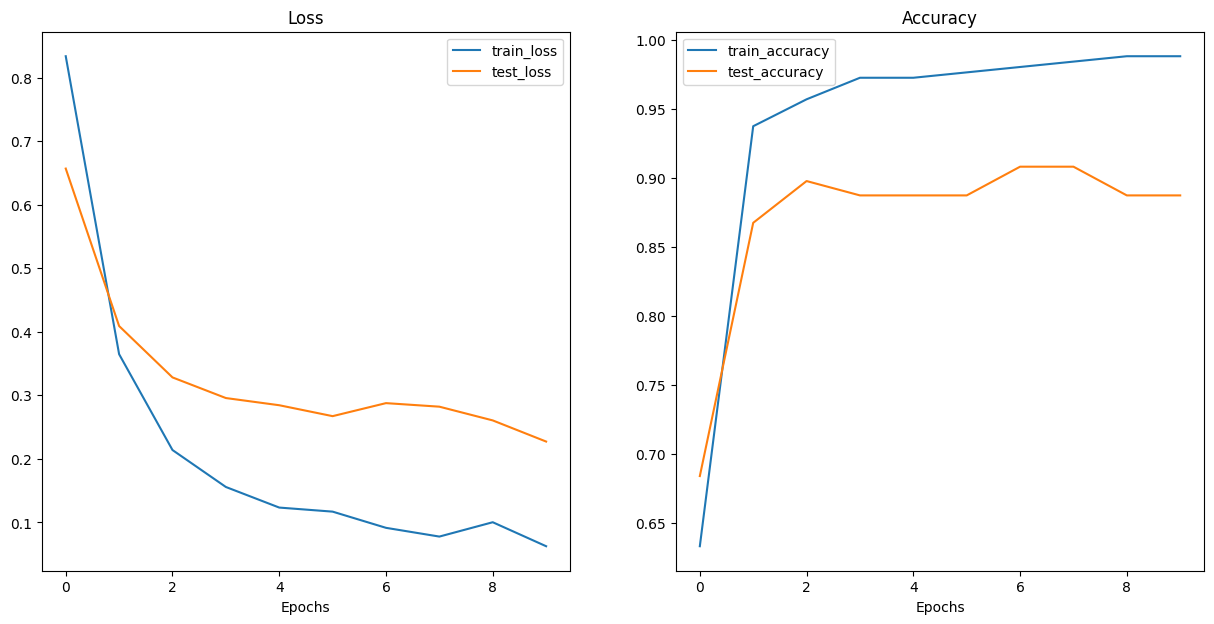

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results=pretrained_model_results)

### 10.6 Save our best performing ViT model

Now we've got a model that perfoms quite well, how about we save it to file and then check it' filesize.

We want to check the filesize because if we wante dto deploy a model to say a website/mobile application, we may have limitations on the size of the model we can deploy.

E.g. a smaller model may be required due to compute restrictions.

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model = pretrained_model,
                 target_dir = "models",
                 model_name = "08_pretrained_vit_features_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_features_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert it to megabytes
pretrained_model_size = Path("models/08_pretrained_vit_features_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_model_size}MB")

Pretrained ViT feature extractor model size: 327MB


Our pretrained ViT gets some of the best resutls we've seen so far on our FoodVision Mini problem, however, the model size is ~11x larger than our next best performing model.

Perhaps the larger model size might cause issues when we go to deploy it (e.g. hard to deploy such a large file/might not make predicions as fast as a smaller model).

## 11. Prediction on a custom image

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_model,
                    image_path=custom_image_path,
                    class_names=class_names)

NameError: name 'data_path' is not defined